<a href="https://www.kaggle.com/code/andriybabiy/02-image-classification-intel-image-classification?scriptVersionId=199794174" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 02_Image_Classification
Using the Intel Image Classification dataset, my goal is to develop and train a deep learining model that will attempt to correctly classify the images.

In [133]:
# import os
# from PIL import Image
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import time
# from tempfile import TemporaryDirectory

# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torchvision
# from torchvision import datasets, transforms, models
# import torchvision.transforms as T
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader, random_split
# from torchvision.utils import make_grid

# from sklearn.metrics import confusion_matrix, f1_score, balanced_accuracy_score, classification_report

# import warnings
# warnings.filterwarnings('ignore')

# from tqdm import tqdm

# torch.cuda.empty_cache()

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

plt.ion() # interactive mode

import warnings
# filter warnings
warnings.filterwarnings('ignore')

In [134]:
resize_size = (224, 224)

# transform_train = transforms.Compose([
#     transforms.Resize(resize_size),
#     transforms.RandomCrop(size=(150, 150)),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# transform = transforms.Compose([
#     transforms.Resize(resize_size),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(resize_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(resize_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## Download and prepare the data for processing

In [135]:
# Kaggle
path_to_dir = '/kaggle/input/intel-image-classification'

pred = '/kaggle/input/intel-image-classification/seg_pred'
test = '/kaggle/input/intel-image-classification/seg_test/seg_test'
train = '/kaggle/input/intel-image-classification/seg_train/seg_train'

path_to_model = '/kaggle/working/'
model_filename = 'baseline_model.pth'
path_to_model_file = os.path.join(path_to_model, model_filename)

# deleting the existing model if exists (optional - if needed to restart from scratch)
# if os.path.exists(path_to_model_file):
#     os.remove(path_to_model_file)
#     print(f"Existing Model '{model_filename}' has been deleted.")
# else:
#     print(f"No existing model file '{model_filename}' found.")

# torch.save(model.state_dict(), path_to_model_file)
path_to_model_file

'/kaggle/working/baseline_model.pth'

In [136]:
image_datasets = {x: datasets.ImageFolder(os.path.join(path_to_dir, 'seg_' + x, 'seg_' + x), data_transforms[x]) for x in ['train', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

class_names = image_datasets['train'].classes

print(dataset_sizes)
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

{'train': 14034, 'test': 3000}
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [137]:
inputs, labels = next(iter(dataloaders['train']))
print("Batch shape:", inputs.shape) 

Batch shape: torch.Size([32, 3, 224, 224])


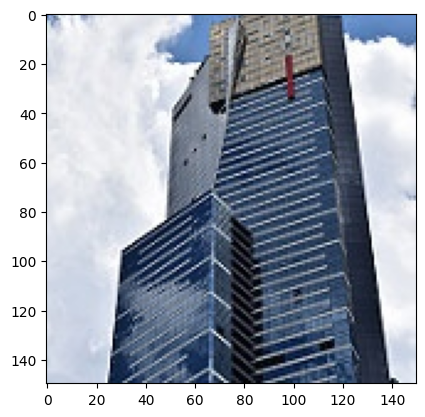

In [138]:
im = Image.open('/kaggle/input/intel-image-classification/seg_test/seg_test/buildings/20057.jpg')
plt.imshow(im)
plt.show() # image will not be displayed without this

### Transformations

In [139]:
# class ImageDataset(Dataset):
#     def __init__(self, data_dir, transform):
#         self.data_dir = data_dir
#         self.transform = transform
#         self.filenames = []
#         self.labels = []
#         self.class_names = []
        
#         # Traverse the directory structure
#         for root, dirs, files in os.walk(data_dir):
#             # Get the class name based on the folder name
#             class_name = os.path.basename(root)
            
#             if len(files) > 0:
#                 # Append all file paths and assign labels based on folder name
#                 for filename in files:
#                     if filename.endswith('.jpg'):
#                         self.filenames.append(os.path.join(root, filename))
#                         # Use the class name (parent folder name) as the label
#                         if class_name not in self.class_names:
#                             self.class_names.append(class_name)
#                         label = self.class_names.index(class_name)
#                         self.labels.append(label)
                        
#     def __len__(self):
#         return len(self.filenames)

#     def __getitem__(self, idx):
#         image_path = self.filenames[idx]
#         image = Image.open(image_path).convert("RGB")  # Open and convert to RGB
#         label = self.labels[idx]
        
#         if self.transform:
#             image = self.transform(image)
        
#         return image, label

In [140]:
# train_dataset = ImageDataset(train, transform_train)
# test_dataset = ImageDataset(test, transform)
# val_dataset = ImageDataset(pred, transform)

In [141]:
# train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
# test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=1)
# val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=1)

### Display image examples

In [142]:
def imshow(images, labels, class_names):
    
    images = images.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)
    plt.imshow(images)
    plt.title(", ".join([class_names[l] for l in labels]))
    plt.show()

In [143]:
dataiter = iter(dataloaders['train'])
images, labels = next(dataiter)

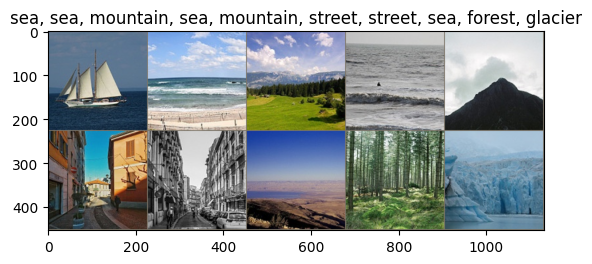

In [144]:
imshow(make_grid(images[:10], nrow=5), labels[:10], class_names)

### Insights about the classes

In [145]:
# print(f"Amount of classes: {len(class_names)}")
# print(f"Classes: {class_names}")
# print(f"Size of training dataset: {len(image_datasets['train'])}")
# print(f"Size of test dataset: {len(image_datasets['test'])}")
# # print(f"Size of validation dataset: {len(val_dataset)}")

# class_counts = {class_name: 0 for class_name in class_names}
# for label in class_names:
#     class_counts[image_datasets['train'].class_names[label]]+=1

# print("\nDistribution of classes in the training dataset:")
# for class_name, count in class_counts.items():
#     print(f"{class_name}: {count}")

## Develop the architecture for a convolutional neural network (CNN) for image classification

### Baseline Model

In [146]:
class BaselineModel(nn.Module):
    def __init__(self, ):
        super(BaselineModel, self).__init__()
        self.num_channels = 32
        
        self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride=1, padding=1)
        
        self.num_features = self._get_num_features()
        
#         self.fc1 = nn.Linear(8*8*self.num_channels*4, self.num_channels*4)
        self.fc1 = nn.Linear(self.num_features, self.num_channels*4)
        self.fc2 = nn.Linear(self.num_channels*4, 6)
        
    def _get_num_features(self):
        dummy_input = torch.zeros(1, 3, 150, 150)
        output = self._forward_conv_layers(dummy_input)
        num_features = output.view(1, -1).size(1)
        return num_features
    
    def _forward_conv_layers(self, x):
        x = self.conv1(x)
        x = F.relu(F.max_pool2d(x, 2))
        x = self.conv2(x)
        x = F.relu(F.max_pool2d(x, 2))
        x = self.conv3(x)
        x = F.relu(F.max_pool2d(x, 2))
        return x
        
    def forward(self, s):
        s = self._forward_conv_layers(s)
        
        s = s.view(s.size(0), -1)
        
        s = F.relu(self.fc1(s))
        s = self.fc2(s)
        
        return F.log_softmax(s, dim=1)

In [147]:
# cuda = torch.cuda.is_available()

# torch.manual_seed(42)
# if cuda:
#     torch.cuda.manual_seed(42)

# device = 'cuda' if cuda else None

In [148]:
model = BaselineModel().to(device)
    
# loading the existing model
# model.load_state_dict(torch.load(path_to_model_file))


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

train_losses = []
train_accs = []

test_losses = []
test_accs = []

num_epochs = 15

In [149]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
# num_ftrs = model_ft.fc.in_features
# # Here the size of each output sample is set to 2.
# # Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
# model_ft.fc = nn.Linear(num_ftrs, 2)

num_ftrs = model_ft.fc.in_features  # This gets the size of the final feature map
model_ft.fc = nn.Linear(num_ftrs, len(class_names))  # Adjust for your dataset

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-05)

In [150]:
model

BaselineModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=41472, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)

In [151]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Train the model on the training dataset

In [152]:
def train_model(model, criterion, optimizer, num_epochs=25):# scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [ ]:
model = train_model(model, criterion, optimizer, num_epochs=15)

In [127]:
model_ft = train_model(model_ft, criterion, optimizer, num_epochs=15)

Epoch 1/15
----------
train Loss: 1.8984 Acc: 0.1446
test Loss: 1.9044 Acc: 0.1490

Epoch 2/15
----------
train Loss: 1.8978 Acc: 0.1430
test Loss: 1.9021 Acc: 0.1483

Epoch 3/15
----------
train Loss: 1.8966 Acc: 0.1464
test Loss: 1.9028 Acc: 0.1510

Epoch 4/15
----------
train Loss: 1.8942 Acc: 0.1462
test Loss: 1.8999 Acc: 0.1470

Epoch 5/15
----------
train Loss: 1.8952 Acc: 0.1484
test Loss: 1.9069 Acc: 0.1483

Epoch 6/15
----------
train Loss: 1.8972 Acc: 0.1471
test Loss: 1.9088 Acc: 0.1430

Epoch 7/15
----------
train Loss: 1.8972 Acc: 0.1438
test Loss: 1.8990 Acc: 0.1387

Epoch 8/15
----------
train Loss: 1.8946 Acc: 0.1441
test Loss: 1.9072 Acc: 0.1467

Epoch 9/15
----------
train Loss: 1.8978 Acc: 0.1438
test Loss: 1.9040 Acc: 0.1497

Epoch 10/15
----------
train Loss: 1.8977 Acc: 0.1479
test Loss: 1.9101 Acc: 0.1417

Epoch 11/15
----------
train Loss: 1.8972 Acc: 0.1471
test Loss: 1.8928 Acc: 0.1463

Epoch 12/15
----------
train Loss: 1.8961 Acc: 0.1487
test Loss: 1.8989 Ac

In [132]:
pretrained_model_filename = 'pretrained_model.pth'
path_to_pretrained_model_file = os.path.join(path_to_model, pretrained_model_filename)

torch.save(model_ft.state_dict(), path_to_pretrained_model_file)
print(f"Model saved to {path_to_pretrained_model_file}")

Model saved to /kaggle/working/pretrained_model.pth


In [15]:
# for epoch in tqdm(range(num_epochs)):
    
#     # train step
    
#     model.train()
    
#     train_epoch_loss = []
#     train_epoch_acc = []
    
#     for i, (train_batch, labels_batch) in tqdm(enumerate(train_dataloader), disable=True):
#         if cuda:
#             train_batch, labels_batch = train_batch.cuda(non_blocking = True), labels_batch.cuda(non_blocking=True)
            
#         output_batch = model(train_batch)
        
#         loss = criterion(output_batch, labels_batch)
        
#         optimizer.zero_grad()
#         loss.backward()
        
#         optimizer.step()
        
#         batch_loss = loss.cpu().detach().numpy()
#         batch_acc = balanced_accuracy_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
#                                            labels_batch.cpu().detach().numpy())
        
#         train_epoch_loss.append(batch_loss)
#         train_epoch_acc.append(batch_acc)
        
#     print(f'Train epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(train_epoch_loss):.4f}, Acc: {np.mean(train_epoch_acc)}')
#     train_accs.append(np.mean(train_epoch_acc))
#     train_losses.append(np.mean(train_epoch_loss))
        
#     # eval step
    
#     model.eval()
    
#     test_epoch_loss = []
#     test_epoch_acc = []
    
#     with torch.no_grad():
#         for i , (test_batch, labels_batch) in enumerate(test_dataloader):
#             if cuda:
#                 test_batch, labels_batch = test_batch.cuda(non_blocking=True), labels_batch.cuda(non_blocking=True)
                
#             output_batch = model(test_batch)
            
#             loss = criterion(output_batch, labels_batch)
            
#             batch_loss = loss.cpu().detach().numpy()
#             batch_acc = balanced_accuracy_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
#                                                labels_batch.cpu().detach().numpy())
            
#             test_epoch_loss.append(batch_loss)
#             test_epoch_acc.append(batch_acc)
            
#     print(f'Test Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(test_epoch_loss):.4f}, Acc: {np.mean(test_epoch_acc)}')
#     test_accs.append(np.mean(test_epoch_acc))
#     test_losses.append(np.mean(test_epoch_loss))

  0%|          | 0/15 [00:00<?, ?it/s]

Train epoch [1/15], Loss: 0.8528, Acc: 0.6970444444718362


  7%|▋         | 1/15 [00:31<07:24, 31.73s/it]

Test Epoch [1/15], Loss: 0.6902, Acc: 0.38182624113475183
Train epoch [2/15], Loss: 0.5626, Acc: 0.805511436224705


 13%|█▎        | 2/15 [00:52<05:28, 25.25s/it]

Test Epoch [2/15], Loss: 0.5913, Acc: 0.40558510638297873
Train epoch [3/15], Loss: 0.4536, Acc: 0.8427811901146184


 20%|██        | 3/15 [01:12<04:36, 23.03s/it]

Test Epoch [3/15], Loss: 0.4746, Acc: 0.4456560283687943
Train epoch [4/15], Loss: 0.3788, Acc: 0.8701853810367478


 27%|██▋       | 4/15 [01:33<04:01, 21.96s/it]

Test Epoch [4/15], Loss: 0.4888, Acc: 0.46366936845660245
Train epoch [5/15], Loss: 0.3172, Acc: 0.8911751319738223


 33%|███▎      | 5/15 [01:53<03:34, 21.45s/it]

Test Epoch [5/15], Loss: 0.5293, Acc: 0.4402482269503547
Train epoch [6/15], Loss: 0.2627, Acc: 0.9099522498824891


 40%|████      | 6/15 [02:13<03:09, 21.06s/it]

Test Epoch [6/15], Loss: 0.5391, Acc: 0.4365691489361702
Train epoch [7/15], Loss: 0.2109, Acc: 0.9276664361644431


 47%|████▋     | 7/15 [02:34<02:46, 20.83s/it]

Test Epoch [7/15], Loss: 0.6079, Acc: 0.45457052797478326
Train epoch [8/15], Loss: 0.1748, Acc: 0.9420518765592798


 53%|█████▎    | 8/15 [02:55<02:26, 20.87s/it]

Test Epoch [8/15], Loss: 0.6451, Acc: 0.45859929078014183
Train epoch [9/15], Loss: 0.1422, Acc: 0.952027756686071


 60%|██████    | 9/15 [03:15<02:04, 20.75s/it]

Test Epoch [9/15], Loss: 0.7038, Acc: 0.4472074468085107
Train epoch [10/15], Loss: 0.1228, Acc: 0.957111942726977


 67%|██████▋   | 10/15 [03:36<01:43, 20.74s/it]

Test Epoch [10/15], Loss: 0.7820, Acc: 0.43865248226950354
Train epoch [11/15], Loss: 0.1029, Acc: 0.9665392576924468


 73%|███████▎  | 11/15 [03:57<01:22, 20.74s/it]

Test Epoch [11/15], Loss: 0.8457, Acc: 0.44893617021276594
Train epoch [12/15], Loss: 0.1015, Acc: 0.9691725422135444


 80%|████████  | 12/15 [04:17<01:01, 20.60s/it]

Test Epoch [12/15], Loss: 0.9123, Acc: 0.45775709219858157
Train epoch [13/15], Loss: 0.0822, Acc: 0.9732788715334273


 87%|████████▋ | 13/15 [04:38<00:41, 20.65s/it]

Test Epoch [13/15], Loss: 0.9515, Acc: 0.46713947990543736
Train epoch [14/15], Loss: 0.0687, Acc: 0.977336614600282


 93%|█████████▎| 14/15 [04:59<00:20, 20.91s/it]

Test Epoch [14/15], Loss: 0.9940, Acc: 0.4499873353596758
Train epoch [15/15], Loss: 0.0739, Acc: 0.9771614781068084


100%|██████████| 15/15 [05:20<00:00, 21.38s/it]

Test Epoch [15/15], Loss: 1.0889, Acc: 0.4372340425531915


In [16]:
torch.save(model.state_dict(), path_to_model_file)
print(f"Model saved to {path_to_model_file}")

Model saved to /kaggle/working/baseline_model.pth


## Analyze the effectiveness of the model using the valid and test datasets

In [129]:
def visualize_predictions(model, dataloader, class_names, num_images=5):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    plt.show()
                    return

                images_so_far += 1
                ax = plt.subplot(num_images//2 + 1, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}')

                # Денормалізація зображення для відображення
                inv_normalize = transforms.Normalize(
                    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                    std=[1/0.229, 1/0.224, 1/0.225]
                )
                inp = inv_normalize(inputs.cpu()[j]).numpy().transpose((1, 2, 0))
                inp = np.clip(inp, 0, 1)

                plt.imshow(inp)

    model.train(mode=was_training)
    plt.tight_layout()
    plt.show()

In [130]:
def plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [19]:
model.load_state_dict(torch.load('baseline_model.pth'))
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Test Accuracy: 0.8177
F1 Score: 0.8175


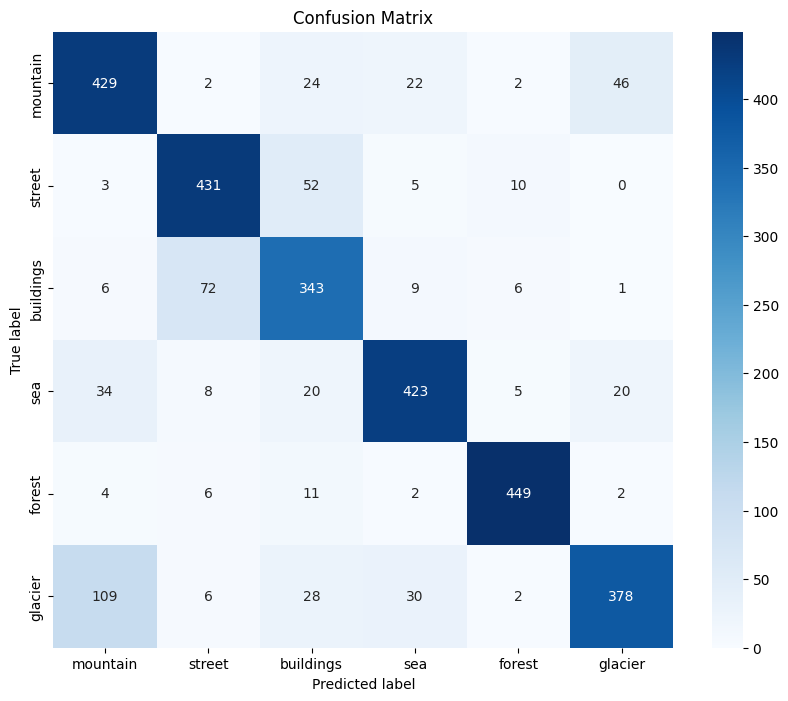

In [20]:
class_names = train_dataset.class_names

# Обчислення точності та F1
test_accuracy = correct / total
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

# Створення матриці помилок
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

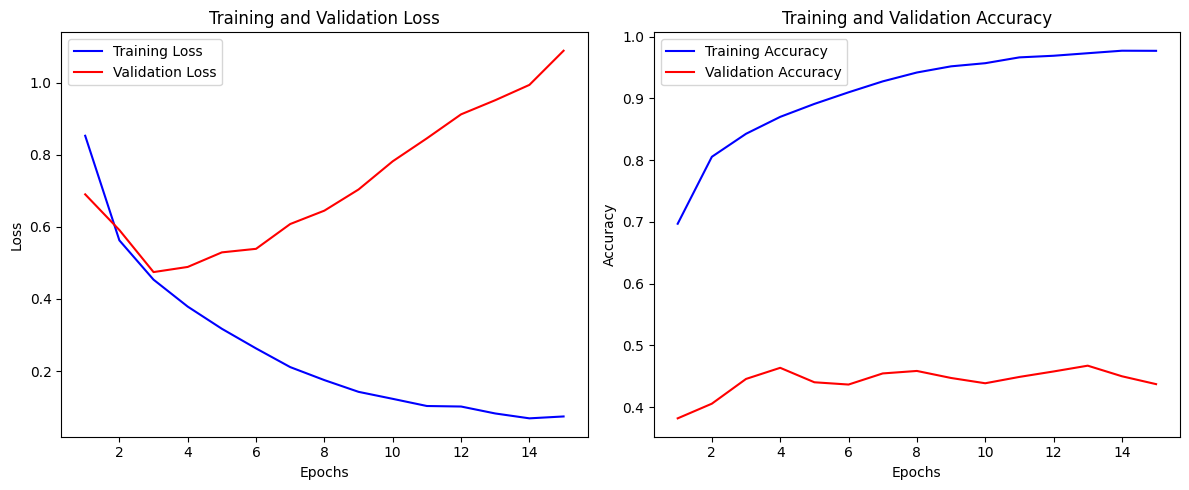

In [21]:
plot_training_metrics(train_losses, train_accs, test_losses, test_accs)

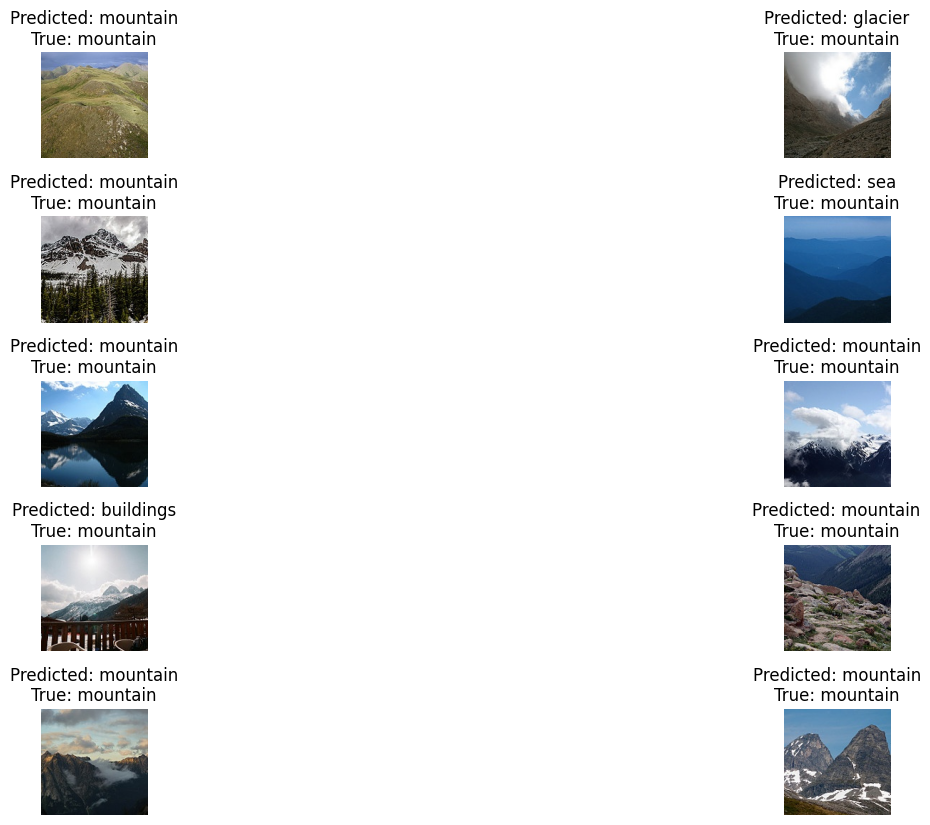

In [22]:
visualize_predictions(model, test_dataloader, test_dataset.class_names, 10)

In [23]:
# %% Function to evaluate the model on the test dataset
def evaluate_model(model):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred

# Get predictions and true labels for test data
y_true, y_pred = evaluate_model(model)

# Calculate F1-score and print classification report
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1-score (weighted): {f1:.4f}')

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

F1-score (weighted): 0.8175
              precision    recall  f1-score   support

    mountain       0.73      0.82      0.77       525
      street       0.82      0.86      0.84       501
   buildings       0.72      0.78      0.75       437
         sea       0.86      0.83      0.85       510
      forest       0.95      0.95      0.95       474
     glacier       0.85      0.68      0.76       553

    accuracy                           0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.82      0.82      3000



## Analysis of a pretrained model

In [24]:
torch.cuda.empty_cache()

In [25]:
model_pretrained = models.resnet18(pretrained=True)

for param in model_pretrained.parameters():
    param.requires_grad = False
    
num_ftrs = model_pretrained.fc.in_features
model_pretrained.fc = nn.Linear(num_ftrs, 2) 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_pretrained = model_pretrained.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 81.0MB/s]


In [26]:
model_pretrained

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
optimizer = torch.optim.Adam(model_pretrained.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss().to(device)

train_losses = []
train_accs = []

test_losses = []
test_accs = []

num_epochs = 15

for epoch in tqdm(range(num_epochs)):
    
    # train step
    
    model_pretrained.train()
    
    train_epoch_loss = []
    train_epoch_acc = []
    
    for i, (train_batch, labels_batch) in tqdm(enumerate(train_dataloader), disable=True):
        if cuda:
            train_batch, labels_batch = train_batch.cuda(non_blocking = True), labels_batch.cuda(non_blocking=True)
            
        output_batch = model_pretrained(train_batch)
        
        loss = criterion(output_batch, labels_batch)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        batch_loss = loss.cpu().detach().numpy()
        batch_acc = balanced_accuracy_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
                                           labels_batch.cpu().detach().numpy())
        
        train_epoch_loss.append(batch_loss)
        train_epoch_acc.append(batch_acc)
        
    print(f'Train epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(train_epoch_loss):.4f}, Acc: {np.mean(train_epoch_acc)}')
    train_accs.append(np.mean(train_epoch_acc))
    train_losses.append(np.mean(train_epoch_loss))
        
    # eval step
    
    model_pretrained.eval()
    
    test_epoch_loss = []
    test_epoch_acc = []
    
    with torch.no_grad():
        for i , (test_batch, labels_batch) in enumerate(test_dataloader):
            if cuda:
                test_batch, labels_batch = test_batch.cuda(non_blocking=True), labels_batch.cuda(non_blocking=True)
                
            output_batch = model_pretrained(test_batch)
            
            loss = criterion(output_batch, labels_batch)
            
            batch_loss = loss.cpu().detach().numpy()
            batch_acc = balanced_accuracy_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
                                               labels_batch.cpu().detach().numpy())
            
            test_epoch_loss.append(batch_loss)
            test_epoch_acc.append(batch_acc)
            
    print(f'Test Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(test_epoch_loss):.4f}, Acc: {np.mean(test_epoch_acc)}')
    test_accs.append(np.mean(test_epoch_acc))
    test_losses.append(np.mean(test_epoch_loss))

  0%|          | 0/15 [00:00<?, ?it/s]/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [0,0,0] Assertion `t >= 0 && t < n_classes` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [1,0,0] Assertion `t >= 0 && t < n_classes` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [3,0,0] Assertion `t >= 0 && t < n_classes` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [4,0,0] Assertion `t >= 0 && t < n_classes` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [6,0,0] Assertion `t >= 0 && t < n_classes` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_f

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
pretrained_model_filename = 'pretrained_model.pth'
path_to_pretrained_model_file = os.path.join(path_to_model, pretrained_model_filename)

torch.save(model_pretrained.state_dict(), path_to_pretrained_model_file)
print(f"Model saved to {path_to_pretrained_model_file}")

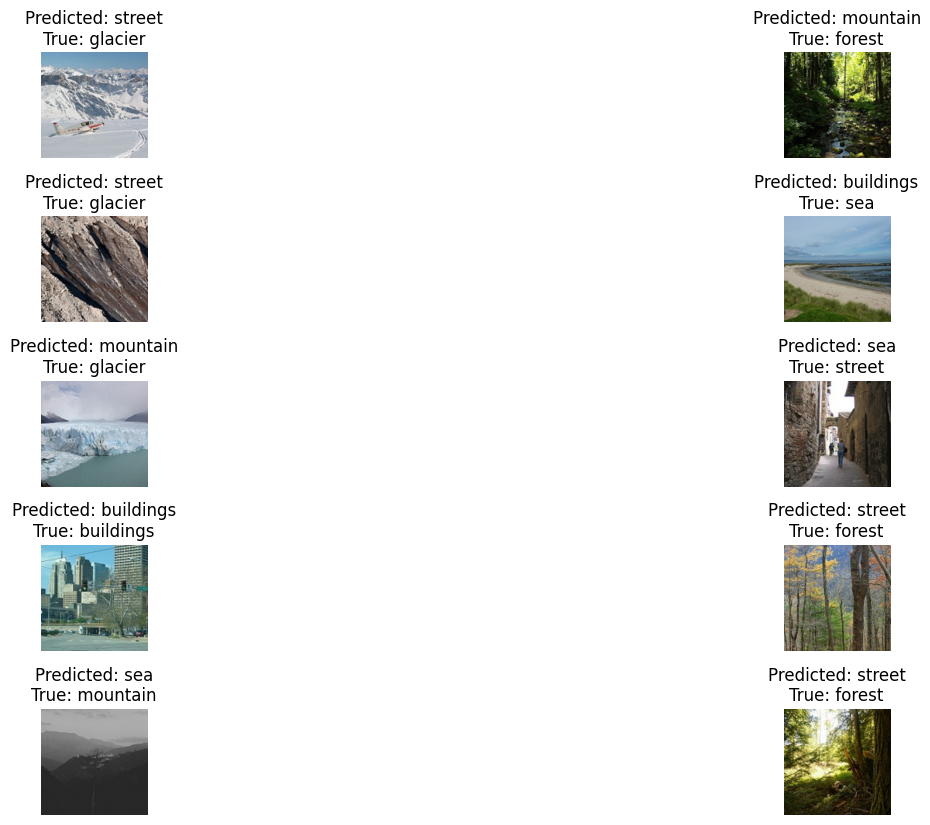

In [154]:
visualize_predictions(model_ft, dataloaders['test'], class_names, 10)

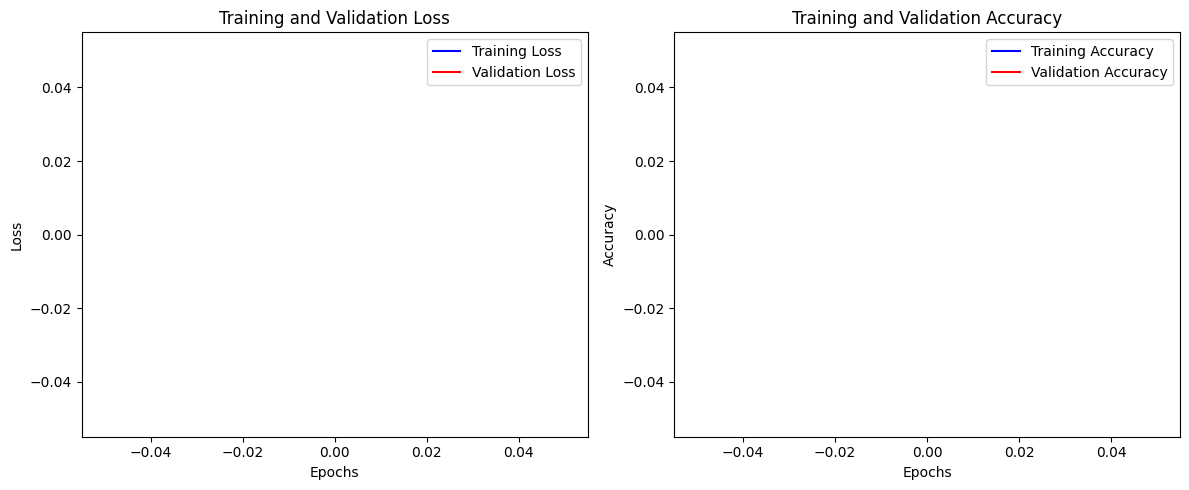

In [155]:
plot_training_metrics(train_losses, train_accs, test_losses, test_accs)

In [157]:
def evaluate_model(model):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred

# Get predictions and true labels for test data
y_true, y_pred = evaluate_model(model_ft)

# Calculate F1-score and print classification report
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1-score (weighted): {f1:.4f}')

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

F1-score (weighted): 0.1193
              precision    recall  f1-score   support

   buildings       0.16      0.08      0.10       437
      forest       0.33      0.00      0.00       474
     glacier       0.11      0.03      0.05       553
    mountain       0.22      0.33      0.27       525
         sea       0.09      0.13      0.10       510
      street       0.13      0.30      0.18       501

    accuracy                           0.15      3000
   macro avg       0.18      0.14      0.12      3000
weighted avg       0.17      0.15      0.12      3000



## Analyze the results and proposal of further potential improvements of the model

After the initial run of the custom model, even during the state of training the model it was clearly evident that the model was overfitting as the model was improving its performance on the train dataset while slowly getting worse on the test dataset. However upon checking the results using a classification_report of the results of evaluating the model using the test dataset it showed an accuracy and F1 score of 83%.

Followining this I decided to also test a transfer model using the resnet18 model. For this I tried to train the model on a similar 15epochs to the custom model and found that the model was not training properly. The resulting model performance was unsatisfactory as at the hyperparameter levels of an Adam optimiser with a learning rate of 1e-3, and I increased the number of epochs to 100 at the same learning rate. These changes did not seem to have much of an impact as the Learning Loss and Accuracy were both oscillating around 1.9 and 17-19% respectively. Following this I attempted to change the learning rate to be 0.01 in order to have the model be more flexible in traversing the data while training in order to better learn and exit potential local minimums, however, once again the results were similarly oscilating in the same ranges. Following ths I decided to change the 

